In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# Make the directories
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [5]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz

In [6]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [17]:
# Import uuid library to generate unique image names
import uuid

In [18]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\fdf1a64e-3206-11ef-bf34-7612b351a14f.jpg'

In [19]:
# # Establish a connection to the webcam
# cap = cv2.VideoCapture(0)

    
# while cap.isOpened(): 
#     ret, frame = cap.read()

   
#     # Cut down frame to 250x250px
#     frame = frame[120:120+250,200:200+250, :]
    
#     # Collect anchors 
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path 
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out anchor image
#         cv2.imwrite(imgname, frame)
    
#     # Collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path 
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out positive image
#         cv2.imwrite(imgname, frame)
    
#     # Show image back to screen
#     cv2.imshow('Image Collection', frame)
    
#     # Breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
        
# # Release the webcam
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows()

In [20]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(3000)

In [21]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [22]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
it = data.as_numpy_iterator()

In [24]:
it.next()

(b'data\\anchor\\2427c5dd-308e-11ef-a021-489ebdf94e09.jpg',
 b'data\\positive\\51c36a34-308e-11ef-a030-489ebdf94e09.jpg',
 1.0)

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [26]:
res = preprocess_twin(*it.next())

In [27]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [28]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [29]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [20]:
#Build Embedding Layer
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [21]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [22]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [7]:
#Build Distance Layer
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)

In [8]:
embedding = make_embedding()

In [9]:
# Anchor image input in the network
input_image = Input(name='input_img', shape=(100,100,3))
    
# Validation image in the network 
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [10]:
inp_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_9>]

In [11]:
l1 = L1Dist()

In [12]:
#Make Siamese Model
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(inp_embedding,val_embedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    # classifier = tf.reshape(classifier, [-1])  # Ensure output shape is (None,)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    

In [13]:
siamese_model = make_siamese_model()

In [14]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (1, None, 4096)           │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
#Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [33]:
# Establish Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [42]:
#Build Train Step Function
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        y = tf.reshape(y, tf.shape(yhat))
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [43]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [44]:
#Build Training Loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [45]:
EPOCHS = 50

In [46]:
batch = train_data.as_numpy_iterator().next()

In [47]:
x = batch[:2]

In [48]:
len(x)

2

In [49]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/stepst
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step/ste
1/1 ━━━━━━━

In [31]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [32]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [52]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [55]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat.flatten()]

[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [56]:
y_true

array([1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [57]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [58]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [59]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1.0 1.0


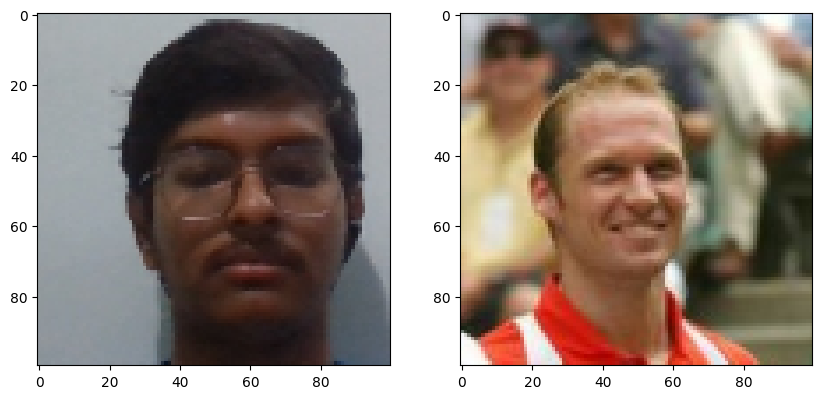

In [80]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [82]:
y_true[0]

0.0

In [67]:
# Save weights
siamese_model.save('siamesemodelv2.keras')

In [62]:
L1Dist

__main__.L1Dist

In [15]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [33]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[[9.9999928e-01],
        [9.9995589e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [2.3357758e-09],
        [2.6087063e-08],
        [9.9999881e-01],
        [9.9999976e-01],
        [2.3470565e-09],
        [1.0000000e+00],
        [9.6783984e-01],
        [1.0000000e+00],
        [9.9999565e-01],
        [1.9341664e-06],
        [8.9480610e-11],
        [9.9961621e-01]]], dtype=float32)

In [34]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (1, None, 4096)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
#Real Time Test
os.listdir(os.path.join('application_data', 'verification_images'))

['4a14eae9-308e-11ef-a3eb-489ebdf94e09.jpg',
 '4a233941-308e-11ef-85fe-489ebdf94e09.jpg',
 '4a31b815-308e-11ef-9ea5-489ebdf94e09.jpg',
 '4a553fd0-308e-11ef-9604-489ebdf94e09.jpg',
 '4a639005-308e-11ef-ac7c-489ebdf94e09.jpg',
 '4a723b26-308e-11ef-a085-489ebdf94e09.jpg',
 '4a771d26-308e-11ef-8a4c-489ebdf94e09.jpg',
 '4a7c148e-308e-11ef-8484-489ebdf94e09.jpg',
 '4a80cf70-308e-11ef-82db-489ebdf94e09.jpg',
 '4a8cd1d9-308e-11ef-9b02-489ebdf94e09.jpg',
 '4aa03d10-308e-11ef-986f-489ebdf94e09.jpg',
 '4ac8bade-308e-11ef-9c9e-489ebdf94e09.jpg',
 '4ad6e119-308e-11ef-804b-489ebdf94e09.jpg',
 '4ae556b9-308e-11ef-a4db-489ebdf94e09.jpg',
 '4afa9471-308e-11ef-a85d-489ebdf94e09.jpg',
 '4b08f73c-308e-11ef-aeef-489ebdf94e09.jpg',
 '4b175fc5-308e-11ef-9a85-489ebdf94e09.jpg',
 '4b1c1282-308e-11ef-9838-489ebdf94e09.jpg',
 '4b3b9381-308e-11ef-be3d-489ebdf94e09.jpg',
 '4b5829b8-308e-11ef-a150-489ebdf94e09.jpg',
 '4b5cf849-308e-11ef-bc78-489ebdf94e09.jpg',
 '4b7768b1-308e-11ef-9025-489ebdf94e09.jpg',
 '4b7c4f6b

In [36]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [37]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\4a14eae9-308e-11ef-a3eb-489ebdf94e09.jpg
application_data\verification_images\4a233941-308e-11ef-85fe-489ebdf94e09.jpg
application_data\verification_images\4a31b815-308e-11ef-9ea5-489ebdf94e09.jpg
application_data\verification_images\4a553fd0-308e-11ef-9604-489ebdf94e09.jpg
application_data\verification_images\4a639005-308e-11ef-ac7c-489ebdf94e09.jpg
application_data\verification_images\4a723b26-308e-11ef-a085-489ebdf94e09.jpg
application_data\verification_images\4a771d26-308e-11ef-8a4c-489ebdf94e09.jpg
application_data\verification_images\4a7c148e-308e-11ef-8484-489ebdf94e09.jpg
application_data\verification_images\4a80cf70-308e-11ef-82db-489ebdf94e09.jpg
application_data\verification_images\4a8cd1d9-308e-11ef-9b02-489ebdf94e09.jpg
application_data\verification_images\4aa03d10-308e-11ef-986f-489ebdf94e09.jpg
application_data\verification_images\4ac8bade-308e-11ef-9c9e-489ebdf94e09.jpg
application_data\verification_images\4ad6e119-308e-11ef-804b-489

In [38]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [39]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [94]:
np.sum(np.squeeze(results) > 0.9)

11

In [95]:
results

[array([[[0.31303516]]], dtype=float32),
 array([[[0.5836606]]], dtype=float32),
 array([[[0.627879]]], dtype=float32),
 array([[[0.9855501]]], dtype=float32),
 array([[[0.91244006]]], dtype=float32),
 array([[[0.95380336]]], dtype=float32),
 array([[[0.9495617]]], dtype=float32),
 array([[[0.8916075]]], dtype=float32),
 array([[[0.47227895]]], dtype=float32),
 array([[[0.10275634]]], dtype=float32),
 array([[[0.04640492]]], dtype=float32),
 array([[[0.10259638]]], dtype=float32),
 array([[[0.8713087]]], dtype=float32),
 array([[[0.8355404]]], dtype=float32),
 array([[[0.9771904]]], dtype=float32),
 array([[[0.74465185]]], dtype=float32),
 array([[[0.14142142]]], dtype=float32),
 array([[[0.09276894]]], dtype=float32),
 array([[[0.14172997]]], dtype=float32),
 array([[[0.36286083]]], dtype=float32),
 array([[[0.42708516]]], dtype=float32),
 array([[[0.6253432]]], dtype=float32),
 array([[[0.1914308]]], dtype=float32),
 array([[[0.24130033]]], dtype=float32),
 array([[[0.52326876]]], dt